In [17]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from scipy.linalg import cholesky
from scipy import special
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
def read_txt(datafile):
    with open(datafile, "r") as file:
        lines = file.readlines()
        data = [[float(num) for num in line.split()] for line in lines]
    return data

In [19]:
def dynamics(dt, state, RW, w_input_noise, num_imus):
    state_next = np.zeros(6+3*num_imus) 
    state_next[0:3] = state[0:3] + state[3:6] * dt                                     # omega
    state_next[3:6] = w_input_noise * np.random.randn(3)                               # omega_dot
    state_next[6:6+3*num_imus] = state[6:6+3*num_imus] + RW * np.random.randn(len(RW)) # Rate random walk state
    return state_next

def dynamics_est(dt, state, num_imus):
    state_next = np.zeros((len(state),6+3*num_imus))
    for i in range(len(state)):
        state_next[i,0:3] = state[i,0:3] + state[i,3:6] * dt          # omega
        state_next[i,3:6] = np.zeros(3)                               # omega_dot
        state_next[i,6:6+3*num_imus] = state[i,6:6+3*num_imus]        # Rate random walk state
    return state_next

In [20]:
def wedge(a):
    Ahat = np.array([[0, -a[2], a[1]],
                    [a[2], 0, -a[0]],
                    [-a[1], a[0], 0]])
    return Ahat

def measurement(state, Rb_si, WN, num_imus):
    meas = np.zeros(3*num_imus)
    for i in range(num_imus):
        Rb_si_sub = Rb_si[i]
        omega = state[0:3]
        omega_dot = state[3:6]
        RW_sub = state[6+3*i:9+3*i]
        omega_i = Rb_si_sub @ omega + WN[i*num_imus:3+i*num_imus]*np.random.randn(3) + RW_sub
        meas[i*3:3+i*3] = omega_i
    return meas

def measurement_est(state_input, Rb_si, num_imus):
    meas = np.zeros((3*num_imus, len(state_input)))
    for j in range(len(state_input)):
        state = state_input[j]
        for i in range(num_imus):
            Rb_si_sub = Rb_si[i]
            omega = state[0:3]
            omega_dot = state[3:6]
            RW_sub = state[6+3*i:9+3*i]
            omega_i = Rb_si_sub @ omega + RW_sub
            meas[i*3:3+i*3, j] = omega_i

    return meas

In [21]:
def UKF_disi(state, Cov, R, Q, y_meas, dt, Rb_si, num_imus):
	
	alpha = 1.0
	kappa = 0
	beta = 0

	# Generate 2n+1 particles for every state
	n = len(state)
	Particles = np.zeros((2*n+1, n))                                                                                                                                                                                                                                                                                                                                                                                                       
	Particles[0] = state
	param_lambda = alpha**2*(n+kappa)-n # labmda is a parameter for pertubing the states
	eigenvalues, eigenvectors = np.linalg.eigh(Cov)
	
	delx = cholesky((n+param_lambda)*Cov)
	# U, s, Vt = np.linalg.svd(Cov)
	# delx = U @ np.diag(np.sqrt(s)) @ Vt
	
	for i in range(n):
		Particles[i+1] = state + delx[i]
		Particles[n+i+1] = state - delx[i]

	# Propagate the particles according to discrete time dynamics (2n+1 particles)
	Particles_prior = dynamics_est(dt, Particles, num_imus)

	# Compute prior state mean and covariance
	w0_m = param_lambda / (n+param_lambda)
	w0_c = param_lambda / (n+param_lambda) + 1.0 - alpha**2 + beta
	wi_mc = 1.0 / (2.0*(n+param_lambda))
	state_prior = w0_m*Particles_prior[0] + np.sum(wi_mc*Particles_prior[1:], axis=0)
	diff = Particles_prior[0] - state_prior
	diff_col = diff[:, np.newaxis]
	diff_row = diff[np.newaxis, :]
	Cov_prior = w0_c * diff_col @ diff_row
	for i in range(1, len(Particles_prior)):
		diff = Particles_prior[i] - state_prior
		diff_col = diff[:, np.newaxis]
		diff_row = diff[np.newaxis, :]
		Cov_prior = Cov_prior + wi_mc * diff_col @ diff_row
	# print(Cov_prior)
	# Cov_prior = w0_c*(Particles_prior[0] - state_prior)*(Particles_prior[0] - state_prior).T
	# for i in range(1, len(Particles_prior)):
	# 	Cov_prior = Cov_prior + wi_mc*(Particles_prior[i] - state_prior)*(Particles_prior[i] - state_prior).T
	Cov_prior = Cov_prior + R
	

	# Regenerate particles
	delx = cholesky((n+param_lambda)*Cov_prior)
	Particles_rev = np.zeros((2*n+1, n))
	Particles_rev[0] = state_prior
	for i in range(n):
		Particles_rev[i+1] = state + delx[i]
		Particles_rev[n+i+1] = state - delx[i]

	# Predict measurements for each particle
	Y_part = measurement_est(Particles_rev, Rb_si, num_imus)

	# Compute weighted measurement mean and covariance
	y_hat = np.sum(wi_mc*Y_part, axis=1)
	S = np.zeros((len(y_hat), len(y_hat)))
	for i in range(len(Y_part[0])):
		y_diff = Y_part[:,i] - y_hat
		y_diff_col = y_diff[:, np.newaxis]
		y_diff_row = y_diff[np.newaxis, :]
		S = S + wi_mc * y_diff_col @ y_diff_row
		# S = S + wi_mc*(Y_part[i] - y_hat)*(Y_part[i] - y_hat).T
	S = S + Q


	# Determine the cross-covariance between the state and observation
	Sig_xz = np.zeros((len(state_prior),len(y_hat)))
	for i in range(len(Y_part[0])):
		Particles_diff = Particles_rev[i] - state_prior
		Y_part_diff = Y_part[:,i] - y_hat
		Particles_col = Particles_diff[:, np.newaxis] 
		Y_part_row = Y_part_diff[np.newaxis, :]

		Sig_xz = Sig_xz + wi_mc * (Particles_col * Y_part_row)
	
	# Compute the Kalman Gain
	K = Sig_xz @ np.linalg.inv(S)

	# Compute the predicted mean and covariance
	state_est = state_prior + K @ (y_meas - y_hat)
	Cov_est = Cov_prior - K @ S @ K.T
	# print(np.linalg.eigvals(Cov_prior))

	return state_est, Cov_est

In [22]:
# def UKF_disi(state, Cov, R, Q, y_meas, dt, Rb_si, QN, GM_param, num_imus):
# 	alpha = 1.0
# 	kappa = 1.0
# 	beta = 1.0

# 	n = len(state)
# 	lambda_ = alpha**2 * (n + kappa) - n  # parameter for perturbing the states
# 	# delx = np.linalg.cholesky((n + lambda_) * Cov)
	

# 	eigenvalues, eigenvectors = np.linalg.eigh((n + lambda_) * Cov)
# 	# Set any small or negative eigenvalues to a small positive value
# 	eigenvalues[eigenvalues < 1e-6] = 1e-6
# 	Cov_corrected = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T
# 	delx = np.linalg.cholesky(Cov_corrected)


	
# 	Particles = np.hstack((state.reshape(-1, 1), state.reshape(-1, 1) + delx.T, state.reshape(-1, 1) - delx.T))

# 	# Propagate the particles according to discrete time dynamics
# 	Particles_prior = dynamics_est(dt, Particles, GM_param, num_imus)

# 	# Compute prior state mean and covariance
# 	w0_m = lambda_ / (n + lambda_)
# 	w0_c = lambda_ / (n + lambda_) + 1.0 - alpha**2 + beta
# 	wi_mc = 1.0 / (2.0 * (n + lambda_))
# 	state_prior = w0_m * Particles_prior[:, 0] + np.sum(wi_mc * Particles_prior[:, 1:], axis=1)
# 	Cov_prior = w0_c * np.outer(Particles_prior[:, 0] - state_prior, Particles_prior[:, 0] - state_prior)
# 	for i in range(1, Particles_prior.shape[1]):
# 		Cov_prior += wi_mc * np.outer(Particles_prior[:, i] - state_prior, Particles_prior[:, i] - state_prior)
# 	Cov_prior += R

# 	# Regenerate particles
# 	delx = np.linalg.cholesky((n + lambda_) * Cov_prior)
# 	Particles_rev = np.hstack((state_prior.reshape(-1, 1), state_prior.reshape(-1, 1) + delx.T, state_prior.reshape(-1, 1) - delx.T))

# 	# Predict measurements for each particle
# 	Y_part = measurement_est(Particles_rev, Rb_si, QN, GM_param, num_imus)

# 	# Compute weighted measurement mean and covariance
# 	y_hat = np.sum(wi_mc * Y_part, axis=1)
# 	S = np.zeros((len(y_hat), len(y_hat)))
# 	for i in range(Y_part.shape[1]):
# 		S += wi_mc * np.outer(Y_part[:, i] - y_hat, Y_part[:, i] - y_hat)
# 	S += Q

# 	# Determine the cross-covariance between the state and observation
# 	Sig_xz = np.zeros((len(state_prior), len(y_hat)))
# 	for i in range(Y_part.shape[1]):
# 		Sig_xz += wi_mc * np.outer(Particles_rev[:, i] - state_prior, Y_part[:, i] - y_hat)

# 	# Compute the Kalman Gain
# 	K = np.linalg.solve(S, Sig_xz.T).T

# 	# Compute the predicted mean and covariance
# 	state_est = state_prior + K.dot(y_meas - y_hat)
# 	Cov_est = Cov_prior - K.dot(S).dot(K.T)

# 	return state_est, Cov_est


In [23]:
# measurements
measurements = np.array(read_txt("data/gyro.txt"))

In [24]:
num_imus = 3

# Other DISI Kit params
# Positions in 3xN where each column is position of 1 IMU
pos_r = np.array([[0.0, 0.0, 0.1],
         [0.0, 0.1, 0.0],
         [0.0, 0.0, 0.0]])
Rb_si = [np.eye(3), np.eye(3), np.eye(3)] # Rotation matrix
w_input_noise = 1e-5
RW  = 1e-4 * np.ones(3*num_imus)
WN  = 1e-4 * np.ones(3*num_imus)

dt = 0.01
time = np.arange(0, 360, 0.01)


# state: omega, alpha, accel, 6 x number_of_imus (RW)
state = np.zeros(6 + 3*num_imus)
state_est = np.zeros(6 + 3*num_imus)
state_hist = np.zeros((len(time), 6 + 3*num_imus))
state_est_hist = np.zeros((len(time), 6 + 3*num_imus))
meas = np.zeros(3*num_imus)
meas_hist = np.zeros((len(time),3*num_imus))


# Covariance of dynamics
R = np.zeros((6 + 3*num_imus, 6 + 3*num_imus))
R[3:6,3:6] = w_input_noise ** 2 * np.eye(3)
R[6:6+3*num_imus, 6:6+3*num_imus] = np.diag(RW**2)

Q = np.diag(WN**2)
Cov_est = 1e-4*np.eye(6+3*num_imus)

for i in range(len(time)):
    print(i)
    state_hist[i] = state
    state = dynamics(dt, state, RW, w_input_noise, num_imus)
    meas = measurements[i]
    meas_hist[i] = meas
    state_est, Cov_est = UKF_disi(state, Cov_est, R, Q, meas, dt, Rb_si, num_imus)
    state_est_hist[i] = state_est


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


LinAlgError: 6-th leading minor of the array is not positive definite

Text(0.5, 1.0, 'omega')

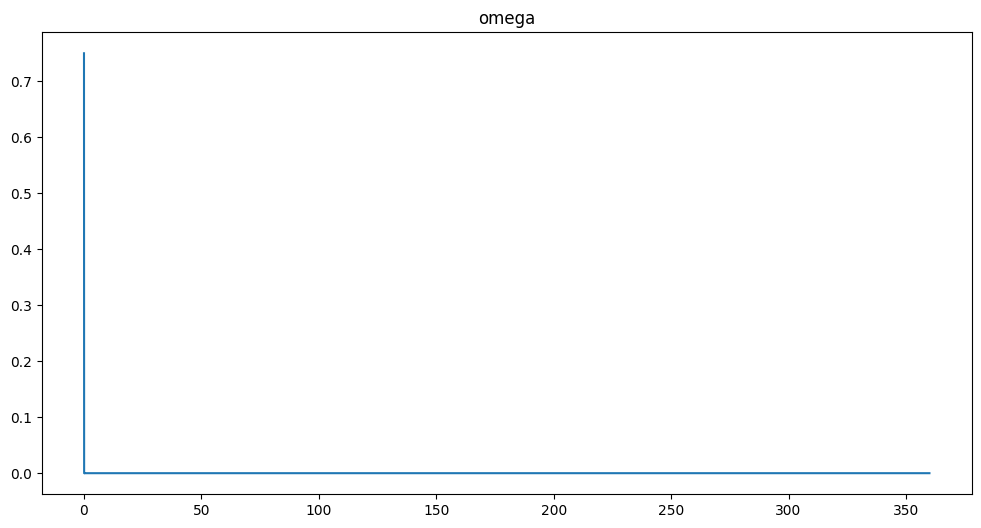

In [25]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_est_hist[:,0])
# plt.plot(time, state_est_hist[:,1])
# plt.plot(time, state_est_hist[:,2])
plt.title("omega")

In [ ]:
print(Cov_est)
eigenvalues, eigenvectors = np.linalg.eigh(Cov_est)
print(eigenvalues)

In [ ]:
alpha = 1.0
kappa = 1.0
beta = 1.0
Cov = 1e-4*np.eye(6+3*num_imus+len(GM_param))

# Generate 2n+1 particles for every state
n = len(state)
Particles = np.zeros((2*n+1, n))                                                                                                                                                                                                                                                                                                                                                                                                       
Particles[0] = state_est_hist[2]
param_lambda = alpha**2*(n+kappa)-n # labmda is a parameter for pertubing the states
delx = np.linalg.cholesky((n+param_lambda)*Cov_est)
print(Cov_est)